# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from main import stochastic_training
from Environment import *
plt.rcParams.update({'font.size': 15})
import pyarrow.feather as feather

In [2]:
training_platform = TrainingPlatform.Notebook
agent_num=1
action_num=2
signal_size =1
learning_rate_theta = 3e-4 / signal_size
learning_rate_wv = 3e-4 / signal_size
learning_rate_principal = 1e-3
memory_size = 1024
batch_size = 1024
training_episodes = int(1e6)
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
algorithm = Algorithm.REGULAR
learning_std = False
fixed_std = 0.3
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
# prior_red_list = logit([2/3, 1/2, 1/3])
prior_red_list = None
score_func = ScoreFunction.QUADRATIC
agent_list = []
evaluation_step = 10
weights_init = WeightsInit.ZERO
report_order = ReportOrder.FIXED
signal_size_list = np.ones(shape=agent_num, dtype=int) * signal_size

metric_dict, principal = stochastic_training(
                             training_platform, agent_list, learning_rate_theta, learning_rate_wv, learning_rate_principal,
                             memory_size, batch_size, training_episodes, decay_rate, beta1, beta2, 
                             algorithm, learning_std, fixed_std, pr_red_ball_red_bucket, pr_red_ball_blue_bucket,
                             prior_red_list, agent_num, action_num, score_func, evaluation_step, weights_init, report_order, signal_size_list)

principal
learning_rate_theta= 0.0003  learning_rate_wv= 0.0003
memory_size= 1024
Updating weights with Regular algorithm.
agent0
learning_rate_theta= 0.0003  learning_rate_wv= 0.0003
memory_size= 1024  standard deviation= 0.3
Updating weights with Regular algorithm.


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [3]:
import os

sequence_number = 1
parent_folder_name = 'Temp' # 'Deterministic' or 'Stochastic'

dir_name = r'ag{}_ac{}_sig{}_lrt{}_te{}_{}_{}_{}_{}_{}_{}/'.format(agent_num, action_num, signal_size, learning_rate_theta, 
                                    training_episodes, algorithm.name, 
                                    'normal' if prior_red_list is None else 'list', score_func.name, weights_init.name, report_order.name, sequence_number)

dir_path = r'./data/{}/{}'.format(parent_folder_name, dir_name)

while os.path.exists(dir_path):
    sequence_number += 1
    dir_name = r'ag{}_ac{}_sig{}_lrt{}_te{}_{}_{}_{}_{}_{}_{}/'.format(agent_num, action_num, signal_size, learning_rate_theta, 
                                    training_episodes, algorithm.name, 
                                    'normal' if prior_red_list is None else 'list', score_func.name, weights_init.name, report_order.name, sequence_number)
    dir_path = r'./data/{}/{}'.format(parent_folder_name, dir_name)
    


os.makedirs(dir_path)

In [4]:
backwards_index = -int(1e6)
print(np.mean(metric_dict['prior_outcome'][backwards_index:]))
print(np.mean(metric_dict['pd_outcome'][backwards_index:]))
print(np.mean(metric_dict['bayesian_outcome'][backwards_index:]))

0.54217
0.57113
0.60203


In [5]:
# loss_df = pd.DataFrame(loss_list,columns=['loss'])
# fig, axs = plt.subplots(2, figsize=(18, 18))
# gradients_box_plot(df=loss_df,bins=10, col_name='loss',color='red',ax=axs[0])
# gradients_box_plot(df=loss_df.iloc[backwards_index:,:], bins=10, col_name='loss', color='blue', ax=axs[1])
# plt.savefig(dir_path + 'loss_boxplot.png')

0.013797414754008077


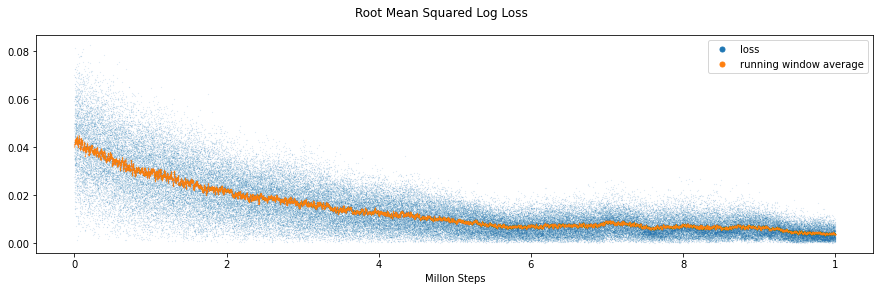

In [6]:
from scipy.ndimage import uniform_filter1d

print(np.mean(metric_dict['loss'][backwards_index:]))
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(metric_dict['loss'],'.',markersize=0.1, label='loss')
average_loss = uniform_filter1d(metric_dict['loss'],size=100)
ax.plot(average_loss,'.', markersize=0.1, label='running window average')
lgnd = ax.legend(loc='upper right',markerscale=100)
xticks = ax.get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xlabels[1:-1])
ax.set_xlabel('Millon Steps')
fig.suptitle('Root Mean Squared Log Loss')
plt.savefig(dir_path + 'loss_dotsplot.png')

In [7]:
metric_df = pd.DataFrame(metric_dict)
with open(dir_path + r'metric', 'wb') as f:
    feather.write_feather(metric_df, f)

In [8]:
check_point_index = int(1e6)
metric_df.head(check_point_index)['loss'].describe().to_csv(dir_path + 'head_loss_describe_table.csv')
print(metric_df.head(check_point_index)['loss'].describe())
metric_df.tail(check_point_index)['loss'].describe().to_csv(dir_path + 'tail_loss_describe_table.csv')
print(metric_df.tail(check_point_index)['loss'].describe())

count    100000.000000
mean          0.013797
std           0.011623
min           0.000008
25%           0.005525
50%           0.009871
75%           0.018509
max           0.082406
Name: loss, dtype: float64
count    100000.000000
mean          0.013797
std           0.011623
min           0.000008
25%           0.005525
50%           0.009871
75%           0.018509
max           0.082406
Name: loss, dtype: float64


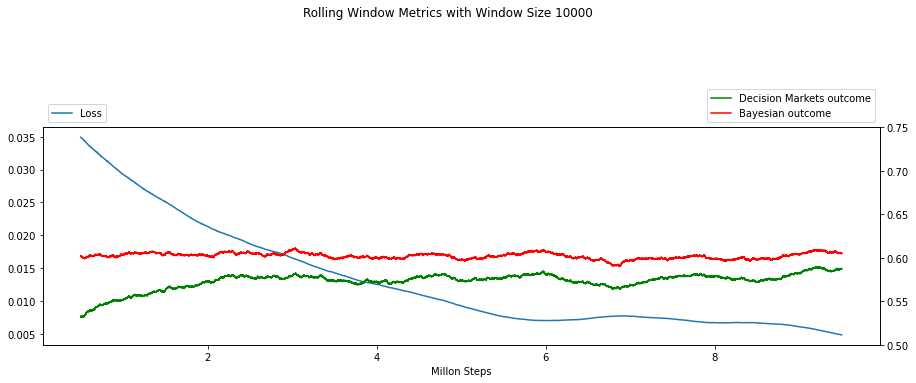

In [9]:
rolling_window_size = 10000
rolling_df = metric_df.loc[:, ['loss', 'pd_outcome', 'bayesian_outcome', 'dr_outcome']].rolling(rolling_window_size, center=True).mean()

fig,ax1 = plt.subplots(figsize=(15,4))
ax2 = ax1.twinx()
ax1.plot(rolling_df['loss'], label='Loss')
ax2.plot(rolling_df['pd_outcome'],'g', label='Decision Markets outcome')
ax2.plot(rolling_df['bayesian_outcome'], 'r', label='Bayesian outcome')
# ax2.plot(rolling_df['dr_outcome'], 'b.',markersize=0.01)
ax2.set_ylim([0.5,0.75])
ax1.legend(loc='lower left', bbox_to_anchor=(0,1))
ax2.legend(loc='lower right', bbox_to_anchor=(1,1))
xticks = ax1.get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
ax1.set_xticks(xticks[1:-1])
ax1.set_xticklabels(xlabels[1:-1])
ax1.set_xlabel('Millon Steps')
fig.suptitle('Rolling Window Metrics with Window Size ' + str(rolling_window_size), y=1.3)
plt.savefig(dir_path + 'loss_reward_plot.png')

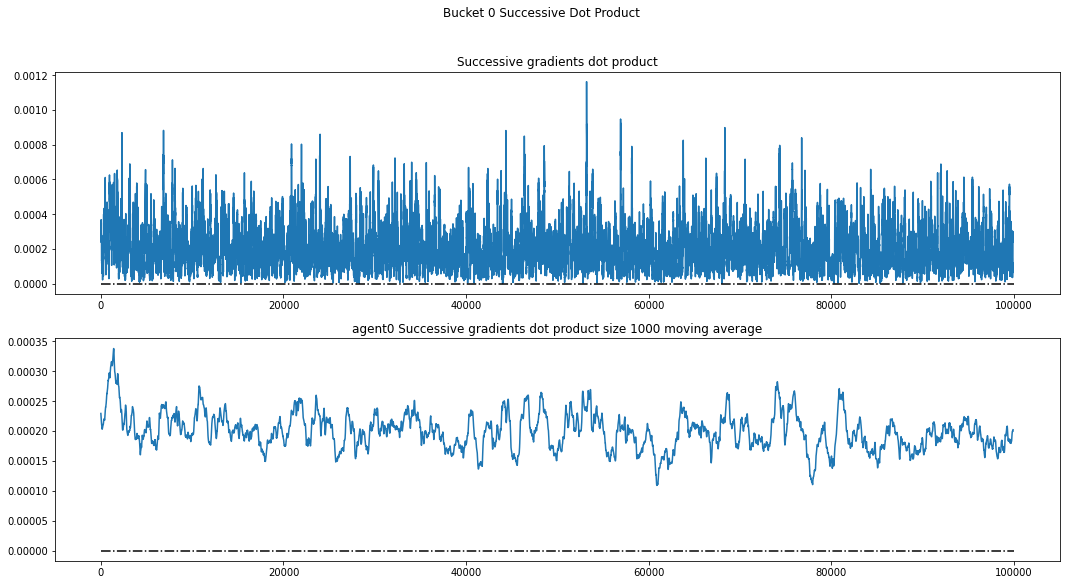

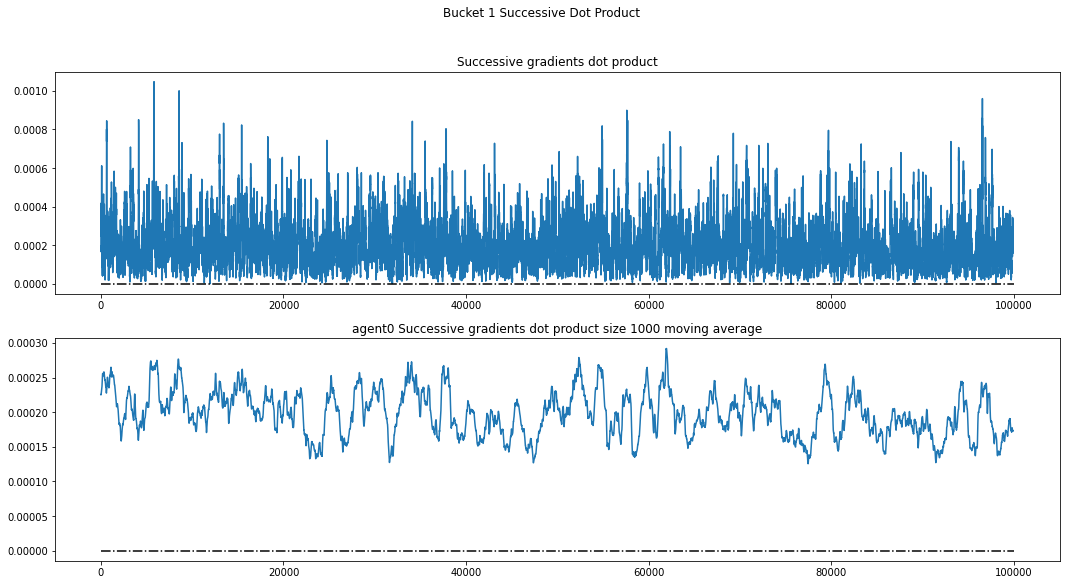

In [10]:
for agent in agent_list:
#     agent.reward_history_plot(top_margin=0.15, bottom_margin=0.15)
#     agent.report_history_plot()
#     agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
#     agent.mean_weights_history_plot()
#     agent.std_gradients_history_plot()
#     agent.std_history_plot()

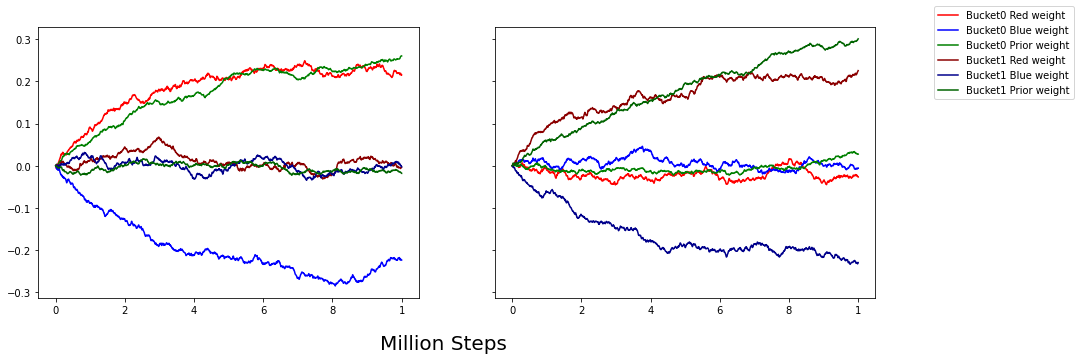

In [11]:
feature_num = 3

fig, axs=plt.subplots(agent_num, action_num, figsize=(15, 5 * agent_num), sharex=True, sharey=True, squeeze=False)


for agent, ag_no in zip(agent_list, range(agent_num)):
    mean_weights_df_list = agent.mean_weights_history_df() 
    reward_df = agent.reward_history_dataframe()
    with open(dir_path + f'{agent.name}_score', 'wb') as f:
        feather.write_feather(reward_df, f)
    # Save the weights
    for no in range(2):
        with open(dir_path + f'{agent.name}_bucket{no}_weights', 'wb') as f:
            feather.write_feather(mean_weights_df_list[no], f)
    
    for df, ac_no in zip(mean_weights_df_list, range(2)):

        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 0],
                               label='Bucket0 Red weight', color='red')
        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 1],
                               label='Bucket0 Blue weight', color='blue')
        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 2],
                               label='Bucket0 Prior weight', color='green')

        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 0],
                               label='Bucket1 Red weight', color='darkred')
        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 1],
                               label='Bucket1 Blue weight', color='darkblue')
        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 2],
                               label='Bucket1 Prior weight', color='darkgreen')
                
# for r_no in range(agent_num):
#     axs[r_no, 0].set_ylabel(f'Agent {r_no}')
#     for c_no in range(action_num):
#         if r_no == 0:
#             axs[r_no, c_no].set_title(f'Bucket {c_no}')
#         axs[r_no, c_no].hlines(y=np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket), xmin=0,

#                             xmax=len(df), colors='red',
#                                      linestyles='dashdot')
#         axs[r_no, c_no].hlines(
#                 y=np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket)), xmin=0,
#                 xmax=len(df), colors='blue',
#                 linestyles='dashdot')
#         axs[r_no, c_no].hlines(y=1, xmin=0, xmax=len(df), colors='green', linestyles='dashdot')
#         axs[r_no, c_no].hlines(y=0, xmin=0, xmax=len(df), colors='black', linestyles='dashdot')

xticks = axs[-1, 0].get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
axs[-1,0].set_xticks(xticks[1:-1])
axs[-1,0].set_xticklabels(xlabels[1:-1])


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.95, 0.95), ncol=1)
fig.text(0.5, 0.0, 'Million Steps', ha='center', va='center', fontsize=20)
# fig.text(0.75, 1, 'Bucket 1', ha='center', va='center', fontsize=20)


plt.savefig(dir_path + 'mean_weights.png', bbox_inches='tight')


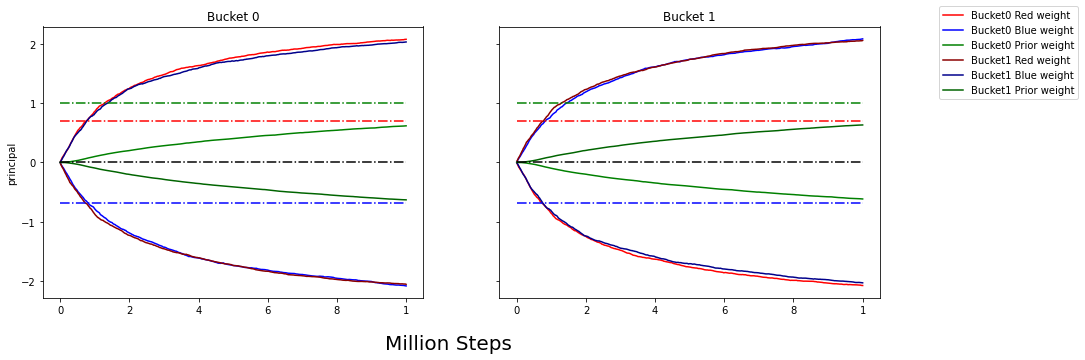

In [12]:
feature_num = 3

fig, axs=plt.subplots(1, action_num, figsize=(15, 5), sharex=True, sharey=True, squeeze=False)

mean_weights_df_list = principal.mean_weights_history_df() 
# reward_df = principal.reward_history_dataframe()
# with open(dir_path + f'{principal.name}_score', 'wb') as f:
#     feather.write_feather(reward_df, f)
# Save the weights
for no in range(2):
    with open(dir_path + f'{principal.name}_bucket{no}_weights', 'wb') as f:
        feather.write_feather(mean_weights_df_list[no], f)

for df, ac_no in zip(mean_weights_df_list, range(2)):

    axs[0, ac_no].plot(df.iloc[1:, 0 * feature_num + 0],
                           label='Bucket0 Red weight', color='red')
    axs[0, ac_no].plot(df.iloc[1:, 0 * feature_num + 1],
                           label='Bucket0 Blue weight', color='blue')
    axs[0, ac_no].plot(df.iloc[1:, 0 * feature_num + 2],
                           label='Bucket0 Prior weight', color='green')

    axs[0, ac_no].plot(df.iloc[1:, 1 * feature_num + 0],
                           label='Bucket1 Red weight', color='darkred')
    axs[0, ac_no].plot(df.iloc[1:, 1 * feature_num + 1],
                           label='Bucket1 Blue weight', color='darkblue')
    axs[0, ac_no].plot(df.iloc[1:, 1 * feature_num + 2],
                           label='Bucket1 Prior weight', color='darkgreen')
                

axs[0, 0].set_ylabel('principal')
for c_no in range(action_num):
    axs[0, c_no].set_title(f'Bucket {c_no}')
    axs[0, c_no].hlines(y=np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket), xmin=0,

                        xmax=len(df), colors='red',
                                 linestyles='dashdot')
    axs[0, c_no].hlines(
            y=np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket)), xmin=0,
            xmax=len(df), colors='blue',
            linestyles='dashdot')
    axs[0, c_no].hlines(y=1, xmin=0, xmax=len(df), colors='green', linestyles='dashdot')
    axs[0, c_no].hlines(y=0, xmin=0, xmax=len(df), colors='black', linestyles='dashdot')

xticks = axs[-1, 0].get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
axs[-1,0].set_xticks(xticks[1:-1])
axs[-1,0].set_xticklabels(xlabels[1:-1])


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.95, 0.95), ncol=1)
fig.text(0.5, 0.0, 'Million Steps', ha='center', va='center', fontsize=20)
# fig.text(0.75, 1, 'Bucket 1', ha='center', va='center', fontsize=20)


plt.savefig(dir_path + 'principal_mean_weights.png', bbox_inches='tight')


NameError: name 'BayesianUpdateMat' is not defined

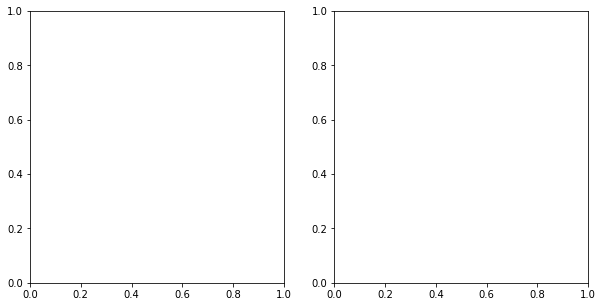

In [13]:
def signal_encode(ball, bucket_no, prior_pair):
    signal_mat = np.zeros((1, 6))
    signal_mat[0, [2, 5]] = np.squeeze(prior_pair)
    signal_mat[0, bucket_no * 3 + ball.value] += 1

    return signal_mat

def context_weights_report(context_array, weights_mat):
    return np.matmul(context_array.reshape(1, 6), weights_mat)


init_logit_prior = (0, 0)

nrow = agent_num
ncol = action_num
fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow), squeeze=False)

for ball in [Ball.RED, Ball.BLUE]:
    for bucket_i in range(action_num):
        for ag_i in range(agent_num):
            
            # Generate a numpy mat average weight for each agent
            mean_weights_df_list = agent_list[ag_i].mean_weights_history_df() 
            bu0_weights = mean_weights_df_list[0].tail(training_episodes // evaluation_step // 4).mean().values.reshape((6, 1))
            bu1_weights = mean_weights_df_list[1].tail(training_episodes // evaluation_step // 4).mean().values.reshape((6, 1))
            weight_mat = np.concatenate((bu0_weights, bu1_weights), axis=1)
            
            reports = np.empty((0, 2), float)

            if ag_i == 0:
                prev_reports = np.zeros(2)
                prev_ba_reports = np.zeros(2)

            signal_array = signal_encode(ball, bucket_i, prev_reports)
            reports = context_weights_report(signal_array, weight_mat)
            ba_signal_array = signal_encode(ball, bucket_i, prev_ba_reports)
            ba_reports = BayesianUpdateMat(ba_signal_array, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
#             ball, bucket_no, logit_prior = two_action_signal_decode(ba_reports)
            bayesian_peer_prediction = BayesianPeerPrediction(expit(ba_reports), pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
            
            axs[ag_i, bucket_i].scatter(expit(reports[0, 0]), expit(reports[0, 1]), marker='o', color=ball.name, label=f'{ball.name} DM')
            axs[ag_i, bucket_i].scatter(bayesian_peer_prediction[0], bayesian_peer_prediction[1], marker='o', color=f'dark{ball.name}', label=f'{ball.name} Bayesian')
            axs[ag_i, bucket_i].set_ylim(0.0, 1)
            axs[ag_i, bucket_i].set_xlim(0.0, 1)
            axs[ag_i, bucket_i].grid(True)
            if ag_i == 0:
                axs[ag_i, bucket_i].scatter(0.5, 0.5, marker='o', color='grey', alpha=0.1)
            else:
                axs[ag_i, bucket_i].scatter(expit(prev_reports[0, 0]), expit(prev_reports[0, 1]), marker='o', color=ball.name, alpha=0.1)
            
            axs[-1, 0].set_xlabel('Report for Bucket 0', fontsize=15)
            axs[-1, 0].set_ylabel('Report for Bucket 1', fontsize=15)
            
            prev_reports = reports.copy()
            prev_ba_reports = bayesian_peer_prediction.copy()
            
axs[0, 0].legend(loc='upper left', ncol=2, fontsize=10)            
axs[0, 0].set_title('Signal from Bucket 0', fontsize=15)
axs[0, 1].set_title('Signal from Bucket 1', fontsize=15)

plt.savefig(dir_path + 'reports.png', bbox_inches='tight')